<h1>GAT 代码复现</h1>

# 数据处理部分

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import torch

## 数据展示

In [2]:
# 数据导入
cora_content_path = '../dataset/cora/cora.content'
cora_content = pd.read_csv(cora_content_path, sep='\t', header=None)
cora_cites_path = '../dataset/cora/cora.cites'
cora_cites = pd.read_csv(cora_cites_path, sep='\t', header=None)

# 打印数据的前5行
print("cora_content:\n",cora_content.head())
print("cora_cites:\n",cora_cites.head())

cora_content:
       0     1     2     3     4     5     6     7     8     9     ...  1425  \
0    31336     0     0     0     0     0     0     0     0     0  ...     0   
1  1061127     0     0     0     0     0     0     0     0     0  ...     0   
2  1106406     0     0     0     0     0     0     0     0     0  ...     0   
3    13195     0     0     0     0     0     0     0     0     0  ...     0   
4    37879     0     0     0     0     0     0     0     0     0  ...     0   

   1426  1427  1428  1429  1430  1431  1432  1433                    1434  
0     0     1     0     0     0     0     0     0         Neural_Networks  
1     1     0     0     0     0     0     0     0           Rule_Learning  
2     0     0     0     0     0     0     0     0  Reinforcement_Learning  
3     0     0     0     0     0     0     0     0  Reinforcement_Learning  
4     0     0     0     0     0     0     0     0   Probabilistic_Methods  

[5 rows x 1435 columns]
cora_cites:
     0        1
0

## 定义辅助函数

In [3]:
# 定义辅助函数热独编码,这里的labels是一个列表
def encode_onehot(labels):
    classes = sorted(list(set(labels))) # set去重，sorted按照从小到大排序
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in enumerate(classes)} # 生成热独编码字典 {类别：热独编码}
    labels_onehot = np.array(list(map(classes_dict.get, labels)), dtype=np.int32) # map函数，对labels中的每个元素进行热独编码,get函数单独使用，返回字典中key对应的value
    return labels_onehot # 返回热独编码后的标签,shape为(N,C)

In [4]:
# 特征数据归一化,输入维度为(N,1433)
def normalize_features(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1)) # 按行求和，shape为(N,1)
    r_inv = np.power(rowsum, -1).flatten() # 求倒数,flatten()将多维数组降为一维
    r_inv[np.isinf(r_inv)] = 0. # 将无穷大的值设置为0
    r_mat_inv = sp.diags(r_inv) # 对角矩阵
    mx = r_mat_inv.dot(mx) # 矩阵相乘，实现归一化，shape为(N,F)
    return mx

In [5]:
# 邻接矩阵数据归一化
def normalize_adj(mx):
    """Symmetrically normalize adjacency matrix."""
    rowsum = np.array(mx.sum(1)) # 按行求和，shape为(N,1)
    r_inv_sqrt = np.power(rowsum, -0.5).flatten() # 求倒数的平方根
    r_inv_sqrt[np.isinf(r_inv_sqrt)] = 0. # 将无穷大的值设置为0
    r_mat_inv_sqrt = sp.diags(r_inv_sqrt) # 对角矩阵
    return mx.dot(r_mat_inv_sqrt).transpose().dot(r_mat_inv_sqrt) # 矩阵相乘

In [6]:
# 计算准确率，输出的output的形状是(N,C),labels的形状是(N,)，其中N是样本数，C是类别数
def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels) # 返回每行最大值的索引，即预测的类别
    correct = preds.eq(labels).double() # 判断是否相等
    correct = correct.sum() # 统计相等的个数
    return correct / len(labels) # 返回准确率

## 数据加载

### 特征以及标签读取

In [7]:
# 加载数据
idx_features_labels = np.genfromtxt(cora_content_path, dtype=np.dtype(str)) # 读取数据
# 从数据中提取特征
features = sp.csr_matrix(idx_features_labels[:, 1:-1], dtype=np.float32) # 提取特征
# 提取标签
labels = encode_onehot(idx_features_labels[:, -1]) # 提取标签,-1表示最后一列，同时进行热独编码

### 生成图状结构

In [8]:
# 生成图结构
idx = np.array(idx_features_labels[:, 0], dtype=np.int32) # 提取索引
idx_map = {j: i for i, j in enumerate(idx)} # 生成索引字典,{原索引：新索引},enumerate将列表转换为索引-值对
# 生成边信息
edges_unordered = np.genfromtxt(cora_cites_path, dtype=np.int32) # 读取边信息，shape=(5429,2)
edges = np.array(list(map(idx_map.get, edges_unordered.flatten())), dtype=np.int32).reshape(edges_unordered.shape) # 生成重新编号的边信息，shape=(5429,2)

### 构建邻接矩阵

In [9]:
adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])), shape=(labels.shape[0], labels.shape[0]), dtype=np.float32) # 生成邻接矩阵的稀疏矩阵，np.ones(edges.shape[0])表示矩阵中所有非零元素的值，edges[:, 0]和edges[:, 1]分别表示这些非零元素的行索引和列索引。
adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj) # 对称归一化邻接矩阵,因为无向图，所以邻接矩阵应该是对称的，这段代码将adj更新为adj和adj.T中的较大值

### 数据归一化

In [10]:
features = normalize_features(features) # 特征归一化
adj = normalize_adj(adj + sp.eye(adj.shape[0])) # 邻接矩阵归一化

### 划分数据集

In [11]:
# 将数据分成训练集、验证集和测试集
idx_train = range(140) # 训练集
idx_val = range(200, 500) # 验证集
idx_test = range(500, 1500) # 测试集

### 将数据转换成能导入模型的格式

In [12]:
adj = torch.FloatTensor(np.array(adj.todense())) # 将邻接矩阵转换为tensor
features = torch.FloatTensor(np.array(features.todense())) # 将特征转换为tensor
labels = torch.LongTensor(np.where(labels)[1]) # 将标签转换为tensor

idx_train = torch.LongTensor(idx_train) # 将训练集索引转换为tensor
idx_val = torch.LongTensor(idx_val) # 将验证集索引转换为tensor
idx_test = torch.LongTensor(idx_test) # 将测试集索引转换为tensor

# 模型定义部分

In [13]:
import torch.nn as nn
import torch.nn.functional as F

第一步计算：
$e_{ij}=a(\mathbf{W}\vec{h}_i,\mathbf{W}\vec{h}_j)$

第二步计算：
$\alpha_{ij}=\mathrm{softmax}_j(e_{ij})=\frac{\exp(e_{ij})}{\sum_{k\in\mathcal{N}_i}\exp(e_{ik})}.$

综合计算公式：
$\alpha_{ij}=\frac{\exp\left(\text{LeakyReLU}\left(\vec{\mathbf{a}}^T[\mathbf{W}\vec{h}_i\|\mathbf{W}\vec{h}_j]\right)\right)}{\sum_{k\in\mathcal{N}_i}\exp\left(\text{LeakyReLU}\left(\vec{\mathbf{a}}^T[\mathbf{W}\vec{h}_i\|\mathbf{W}\vec{h}_k]\right)\right)}$

h'计算公式：
$\vec{h}_i'=\sigma\left(\sum_{j\in\mathcal{N}_i}\alpha_{ij}\mathbf{W}\vec{h}_j\right).$

### 单层注意力层

In [14]:
class GSingleLayer(nn.Module):
    def __init__(self, in_features, out_features, dropout, alpha, concat = True): # in_features是输入特征维度，out_features是输出特征维度，dropout是dropout的概率，alpha是leakyrelu的参数，concat是否要拼接
        super(GSingleLayer, self).__init__()
        self.dropout = dropout # 在数据量较少的时候，可以使用dropout防止过拟合
        self.in_features = in_features # 输入特征维度F
        self.out_features = out_features # 输出特征维度F'
        self.concat = concat # 是否要拼接，对于中间层，需要拼接因为这里使用的是多头注意力，但是对于最后一层就不需要拼接直接计算平均值
        self.alpha = alpha # leakyrelu的参数

        # 定义权重矩阵
        self.W = nn.Parameter(torch.empty(size=(in_features, out_features))) # 定义权重矩阵,shape=[F,F'],这里跟论文中的不一样是后面在将数据导入模型的时候纬度是[N,F]。这里要相应进行调整
        # 用Xavier方法初始化权重矩阵
        nn.init.xavier_uniform_(self.W.data, gain=1.414) # 使用Xavier方法初始化权重矩阵

        # 定义权重向量a
        self.a = nn.Parameter(torch.empty(size=(2*out_features, 1))) # 定义权重向量a,shape=[2F',1]
        # 用Xavier方法初始化权重向量a
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

        # 定义leakyrelu激活函数
        self.leakyrelu = nn.LeakyReLU(self.alpha)

    # 定义在这一层节点会进行什么操作
    # h就是论文中的输入特征集合，adj就是邻接矩阵
    def forward(self, h, adj):
        # 首先是e的计算，矩阵的使用用高维的避免了循环遍历
        Wh = torch.mm(h, self.W) # shape [N, F']
        Wh1 = torch.matmul(Wh,self.a[:self.out_features, :]) # shape [N, 1], 这里将a拆开相当于后面将两个拼接起来
        Wh2 = torch.matmul(Wh,self.a[self.out_features:, :]) # shape [N, 1]，这里一定要记住不能少了后面这个冒号！！！！！
        e = self.leakyrelu(Wh1 + Wh2.T) # shape [N, N]，同时这里使用了广播相加

        # 计算注意力系数a
        zero_vec = -9e15*torch.ones_like(e) # 生成负无穷矩阵，方便后续经过softmax函数直接变成0
        attention = torch.where(adj > 0, e, zero_vec) # 前面计算了所有节点之间的相关性系数，这里筛选出有边关系的保留attention,剩下的不保留
        attention = F.softmax(attention, dim = 1)
        attention = F.dropout(attention, self.dropout, training = self.training)
        h_prime = torch.matmul(attention, Wh) # 将所有的attention和Wh相乘得到当前层的输出

        if self.concat: # 如果是拼接的话
            return F.elu(h_prime)
        else:
            return h_prime

### GAT网络架构

In [15]:
class GAT_Network(nn.Module):
    def __init__(self, nfeature, nhidden, nclass, dropout, alpha, nheads): # nfeature是输入特征的维度，nhidden是隐藏层的维度，nclass是输出的类别数，dropout是dropout的概率，alpha是leakyrelu的参数，nheads是多头注意力的头数
        super(GAT_Network, self).__init__()
        self.dropout = dropout
        self.nheads = nheads 
        # 定义多个注意力层
        self.attentions = [GSingleLayer(nfeature, nhidden, dropout, alpha) for _ in range(nheads)] # 定义多个注意力层，输出是[nhidden, nheads]
        for i, attention in enumerate(self.attentions):
            # 将多个注意力层加入到模型中，并行计算
            self.add_module('attention_{}'.format(i), attention)
        # 定义输出层，输出层的输入维度就是上一层[nhidden, nheads]，由于这里是最后一层，根据论文中说的就不进行拼接了
        self.out_att = GSingleLayer(nhidden * nheads, nclass, dropout, alpha, concat = False)
    
    # 定义在网络架构中信息的传递规则
    def forward(self, x, adj):
        x = F.dropout(x, self.dropout, training = self.training) # dropout
        x = torch.cat([att(x, adj) for att in self.attentions], dim = 1) # 将多个注意力层的输出拼接起来
        x = F.dropout(x, self.dropout, training = self.training)
        x = F.elu(self.out_att(x, adj)) # 用elu激活函数
        return F.log_softmax(x, dim = 1) # softmax将输出转换为概率分布

# 模型训练以及评价

In [16]:
import torch.optim as optim
from torch.autograd import Variable
import argparse
import random
import time
import glob
import os

## 定义训练参数

In [17]:
# 设置随机种子,保证实验的可重复性
seed = 72
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
# 定义训练参数序列
param = {

    "epochs": 200, # "Number of epochs to train."
    'lr': 0.005,  # "Initial learning rate."
    'weight_decay': 5e-4,  # "Weight decay (L2 loss on parameters)."
    'hidden': 8,  # "Number of hidden units."
    'nb_heads': 8,  # "Number of head attentions."
    'dropout': 0.6,  # "Dropout rate (1 - keep probability)."
    'alpha': 0.2,  # "Alpha for the leaky_relu."
    'patience': 100,    # "Patience"
    'fastmode': False  # "Activate fast mode (i.e. validate during training)."
    
}

## 定义模型和优化器

In [18]:
model_transductive = GAT_Network(
    nfeature = features.shape[1],
    nhidden = param["hidden"],
    nclass = labels.max().item() + 1,
    dropout = param["dropout"],
    alpha = param["alpha"],
    nheads = param["nb_heads"]
)
optimizer = optim.Adam(
    model_transductive.parameters(), # 模型参数
    lr = param["lr"],
    weight_decay = param["weight_decay"]
)

## 将所有信息加载到GPU

In [19]:
if torch.cuda.is_available():
    model_transductive.cuda()
    features = features.cuda()
    adj = adj.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_val = idx_val.cuda()
    idx_test = idx_test.cuda()

# 将数据转换为Variable,目的是为了计算梯度
features, adj, labels = Variable(features), Variable(adj), Variable(labels) 
# 打印数据形状
print(features.shape,adj.shape,labels.shape)

torch.Size([2708, 1433]) torch.Size([2708, 2708]) torch.Size([2708])


## 训练函数和测试函数

In [20]:
def train(epoch):
    t = time.time()
    # 训练模型
    model_transductive.train() # 训练模式
    optimizer.zero_grad() # 梯度清零
    output = model_transductive(features, adj) # 前向传播
    loss_train = F.nll_loss(output[idx_train], labels[idx_train]) # 计算损失
    acc_train = accuracy(output[idx_train], labels[idx_train]) # 计算准确率
    loss_train.backward() # 反向传播
    optimizer.step() # 更新参数

    if not param["fastmode"]: # 如果不是快速模式,验证集和测试集也要进行训练
        model_transductive.eval()
        output = model_transductive(features, adj)

    loss_val = F.nll_loss(output[idx_val], labels[idx_val])
    acc_val = accuracy(output[idx_val], labels[idx_val])
    print('Epoch: {:04d}'.format(epoch+1),
        'loss_train: {:.4f}'.format(loss_train.item()),
        'acc_train: {:.4f}'.format(acc_train.item()),
        'loss_val: {:.4f}'.format(loss_val.item()),
        'acc_val: {:.4f}'.format(acc_val.item()),
        'time: {:.4f}s'.format(time.time() - t))
    
    return loss_val.data.item()

In [21]:
def test():
    model_transductive.eval() # 测试模式
    output = model_transductive(features, adj) # 前向传播
    loss_test = F.nll_loss(output[idx_test], labels[idx_test]) # 计算损失
    acc_test = accuracy(output[idx_test], labels[idx_test]) # 计算准确率
    print("Test set results for dataset {} in transductive way:".format("cora"),
        "loss= {:.4f}".format(loss_test.item()),
        "accuracy= {:.4f}".format(acc_test.item()))

## 开始训练

Epoch: 0001 loss_train: 1.9484 acc_train: 0.0929 loss_val: 1.9408 acc_val: 0.2833 time: 2.3772s
Epoch: 0002 loss_train: 1.9371 acc_train: 0.2071 loss_val: 1.9315 acc_val: 0.5367 time: 0.1059s
Epoch: 0003 loss_train: 1.9255 acc_train: 0.2786 loss_val: 1.9219 acc_val: 0.6467 time: 0.1049s
Epoch: 0004 loss_train: 1.9129 acc_train: 0.4571 loss_val: 1.9122 acc_val: 0.6433 time: 0.1045s
Epoch: 0005 loss_train: 1.9053 acc_train: 0.4429 loss_val: 1.9027 acc_val: 0.6400 time: 0.1109s
Epoch: 0006 loss_train: 1.8876 acc_train: 0.5429 loss_val: 1.8933 acc_val: 0.6500 time: 0.1032s
Epoch: 0007 loss_train: 1.8828 acc_train: 0.5500 loss_val: 1.8838 acc_val: 0.6500 time: 0.1059s
Epoch: 0008 loss_train: 1.8656 acc_train: 0.5714 loss_val: 1.8740 acc_val: 0.6333 time: 0.1040s
Epoch: 0009 loss_train: 1.8482 acc_train: 0.5500 loss_val: 1.8640 acc_val: 0.6267 time: 0.1077s
Epoch: 0010 loss_train: 1.8381 acc_train: 0.5714 loss_val: 1.8539 acc_val: 0.6267 time: 0.1089s
Epoch: 0011 loss_train: 1.8292 acc_train

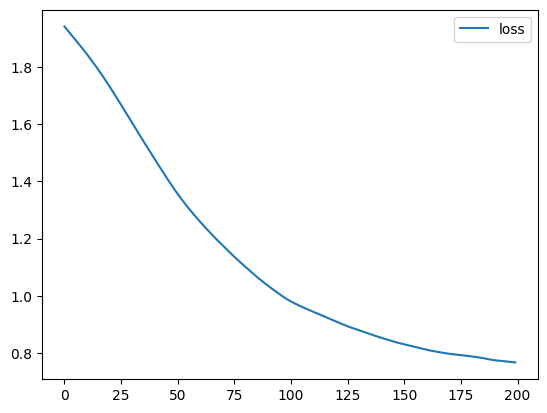

In [22]:
import os

t_total = time.time()
loss_values = []
bad_counter = 0
best = param["epochs"] + 1
best_epoch = 0
output_dir = '../output'  # 上一级目录的output文件夹
os.makedirs(output_dir, exist_ok=True)  # 如果目录不存在，则创建目录

for epoch in range(param["epochs"]):
    loss_values.append(train(epoch))
    # 保存模型
    torch.save(model_transductive.state_dict(), os.path.join(output_dir, '{}.pkl'.format(epoch)))
    # 如果验证集的损失值小于最好的损失值，就更新最好的损失值
    if loss_values[-1] < best:
        best = loss_values[-1]
        best_epoch = epoch
        bad_counter = 0
    else:
        bad_counter += 1
    # 如果连续bad_counter次验证集的损失值都没有更新，就停止训练
    if bad_counter == param["patience"]:
        break

    file = glob.glob(os.path.join(output_dir, '*.pkl'))
    for f in file:
        epoch_nb = int(os.path.basename(f).split('.')[0])
        if epoch_nb < best_epoch:  # 每个epoch都只会保留最好的模型，把在最好模型之前的模型都删除
            os.remove(f)

files = glob.glob(os.path.join(output_dir, '*.pkl'))
for f in files:
    epoch_nb = int(os.path.basename(f).split('.')[0])
    if epoch_nb > best_epoch:  # 训练结束以后删除epoch在最好模型之后的模型，因为这些模型都是无用的
        os.remove(f)

print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

# 加载最好的模型
model_transductive.load_state_dict(torch.load(os.path.join(output_dir, '{}.pkl'.format(best_epoch))))
# 画出损失值的变化
plt.plot(loss_values, label='loss')
plt.legend()
plt.show()

In [23]:
test()  # 测试模型

Test set results for dataset cora: loss= 0.8177 accuracy= 0.8380
